In [116]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from itertools import product
from stable_baselines3 import A2C
from pathlib import Path
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import copy
from tqdm import trange
import os
import pandas as pd
import joblib
from copy import copy
from gym.wrappers import TimeLimit
from tqdm import tqdm, trange
from skmultiflow.lazy import KNNRegressor

In [68]:
path = Path.cwd()
device = 'cpu'

# OOD environments instantiation

In [69]:

def get_cartpole_values():
    default_values = {}
    values = {}

    default_values['Gravity'] = 9.8
    values['Gravity'] = [0.98, 1.09, 1.23, 1.4, 1.63, 1.96, 2.45, 3.27, 4.9, 19.6, 29.4, 39.2, 49.0, 58.8, 68.6, 78.4, 88.2, 98.0]

    default_values['Mass_cart'] = 1.0
    values['Mass_cart'] = [0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.3333, 0.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

    default_values['Length_pole'] = 0.5
    values['Length_pole'] = [0.05, 0.0556, 0.0625, 0.0714, 0.0833, 0.1, 0.125, 0.1667, 0.25, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

    default_values['Mass_pole'] = 0.1
    values['Mass_pole'] = [0.01, 0.0111, 0.0125, 0.0143, 0.0167, 0.02, 0.025, 0.0333, 0.05, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    default_values['Force_magnitude'] = 10.0
    values['Force_magnitude'] = [1.0, 1.1111, 1.25, 1.4286, 1.6667, 2.0, 2.5, 3.3333, 5.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]

    return default_values, values

def instanciate_cartpole_old(gravity, mass_cart, length_pole, mass_pole, force_magnitude):
    env = gym.make("CartPole-v1")
    env.gravity = gravity
    env.masscart = mass_cart
    env.masspole = mass_pole
    env.total_mass = env.masspole + env.masscart
    env.length = length_pole  # actually half the pole's length
    env.polemass_length = env.masspole * env.length
    env.force_mag = force_magnitude
    return env

def instanciate_cartpole(config):
    env = gym.make("CartPole-v1").env
    env.gravity = config['Gravity']
    env.masscart = config['Mass_cart']
    env.masspole = config['Mass_pole']
    env.total_mass = env.masspole + env.masscart
    env.length =  config['Length_pole'] # actually half the pole's length
    env.polemass_length = env.masspole * env.length
    env.force_mag = config['Force_magnitude']
    env = TimeLimit(env, 400)
    return env


In [70]:

def get_pendulum_values():
    default_values = {}
    values = {}

    default_values['Gravity'] = 10.0
    values['Gravity'] = [0.5, 1.0, 2.0, 5.0, 20.0, 50.0, 100.0, 200.0]

    default_values['Mass_pole'] = 1.0
    values['Mass_pole'] = [0.05, 0.1, 0.2, 0.5, 2.0, 5.0, 10.0, 20.0]

    default_values['Length_pole'] = 1.0
    values['Length_pole'] = [0.05, 0.1, 0.2, 0.5, 2.0, 5.0, 10.0, 20.0]
    
    default_values['Max_speed'] = 8.0
    values['Max_speed'] = [0.4, 0.8, 1.6, 4.0, 16.0, 40.0, 80.0, 160.0]

    default_values['Max_torque'] = 2.0
    values['Max_torque'] = [0.1, 0.2, 0.4, 1.0, 4.0, 10.0, 20.0, 40.0]

    return default_values, values

def instanciate_pendulum_old(gravity, mass_pole, length_pole, max_speed, max_torque):
    env = gym.make("Pendulum-v1")
    env.max_speed = max_speed
    env.max_torque = max_torque
    env.g = gravity
    env.m = mass_pole
    env.l = length_pole
    return env

def instanciate_pendulum(config):
    env = gym.make("Pendulum-v1").env
    env.max_speed = config['Max_speed']
    env.max_torque = config['Max_torque']
    env.g = config['Gravity']
    env.m = config['Mass_pole']
    env.l = config['Length_pole']
    return env.env

In [71]:
def get_possible_combinaisons(values):
    return [x for x in product(*list(values.values()))]

In [72]:
default_values, values = get_cartpole_values()

In [73]:
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

In [74]:
def get_ood_configs(default_values, values):
    """
    Gives ood config that differ form the defalut config by only one value
    """
    ood_configs = []
    #changes = []
    for key in values:
        
        for value in values[key]:
            ood_config = copy(default_values)
            if value != default_values[key]:
                ood_config[key] = value
                ood_config['change'] = key
                ood_configs.append(ood_config)
                #changes.append({key:value})

    return ood_configs #, changes

ood_configs = get_ood_configs(default_values, values)
len(ood_configs)
ood_configs[0]

{'Gravity': 0.98,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0,
 'change': 'Gravity'}

In [75]:
{'Force_magnitude': 70.0}.keys()

dict_keys(['Force_magnitude'])

In [76]:

ood_env = instanciate_cartpole(ood_configs[0])
print(ood_env)
ood_env.close()

<TimeLimit<CartPoleEnv<CartPole-v1>>>


In [77]:
def get_possible_combinaisons(values):
    return [x for x in product(*list(values.values()))]

# Evaluate OOD impact

### Original environment

In [35]:



def evaluate(env, agent, nb_episodes=100, render=False):
    total_rewards = []
    observation = env.reset()
    
    for ep in range(nb_episodes):
        total_reward = 0.0
        observation = env.reset()
        terminated = False
        
        while terminated is False:
            action, _state = agent.predict(observation)
            #action = env.action_space.sample()
            observation, reward, terminated, info = env.step(action)
            total_reward += reward

            if render:
                env.render()
                
        total_rewards.append(total_reward)

            
    env.close()
    
    return np.mean(total_rewards), np.std(total_rewards)



In [36]:
#agent = A2C.load(path/'Agents'/'Pendulum-v1.zip', env=env)

#agent = A2C.load(path/'Agents'/'CartPole-v1.zip', env=env)
env = instanciate_cartpole(default_values)

path_agent = path / 'Agents' / 'trained_CartPole_10000'
#if os.path.exists(path_agent):
#    agent = A2C.load(path_agent)
#else:
agent = A2C('MlpPolicy', env)
agent.learn(10000)
agent.save(path_agent)

evaluate(env, agent, nb_episodes=10, render=True)

(360.6, 65.83646406057969)

In [37]:
evaluate(env, agent, render=True)

(323.43, 85.89205492942871)

In [38]:
ood_configs[0]

{'Gravity': 0.98,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0,
 'change': 'Gravity'}

In [39]:
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

In [40]:
ood_env = instanciate_cartpole(ood_configs[0])
#agent = A2C.load(path/'Agents'/'CartPole-v1.zip', env=ood_env)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
evaluate(ood_env, agent, render=False)

(400.0, 0.0)

In [41]:
ood_env = instanciate_cartpole(ood_configs[-1])
print(ood_env.gravity)
evaluate(ood_env, agent, render=False)

9.8


(56.94, 36.66437507990556)

### Evaluation 

In [42]:
default_values, values = get_cartpole_values()
results = {}
std_results = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path/'Agents'/'trained_CartPole_10000', env=ood_env)
    mean_reward, std_reward = evaluate(ood_env, agent)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)
    #print(config, mean_reward)
    



100%|███████████████████████████████████████████| 90/90 [03:12<00:00,  2.14s/it]


In [43]:
L = copy(values['Gravity'])
L.append(9.8)
print(sorted(L))

[0.98, 1.09, 1.23, 1.4, 1.63, 1.96, 2.45, 3.27, 4.9, 9.8, 19.6, 29.4, 39.2, 49.0, 58.8, 68.6, 78.4, 88.2, 98.0]


In [44]:
original_result, original_std_result

(334.0, 77.4299683585109)

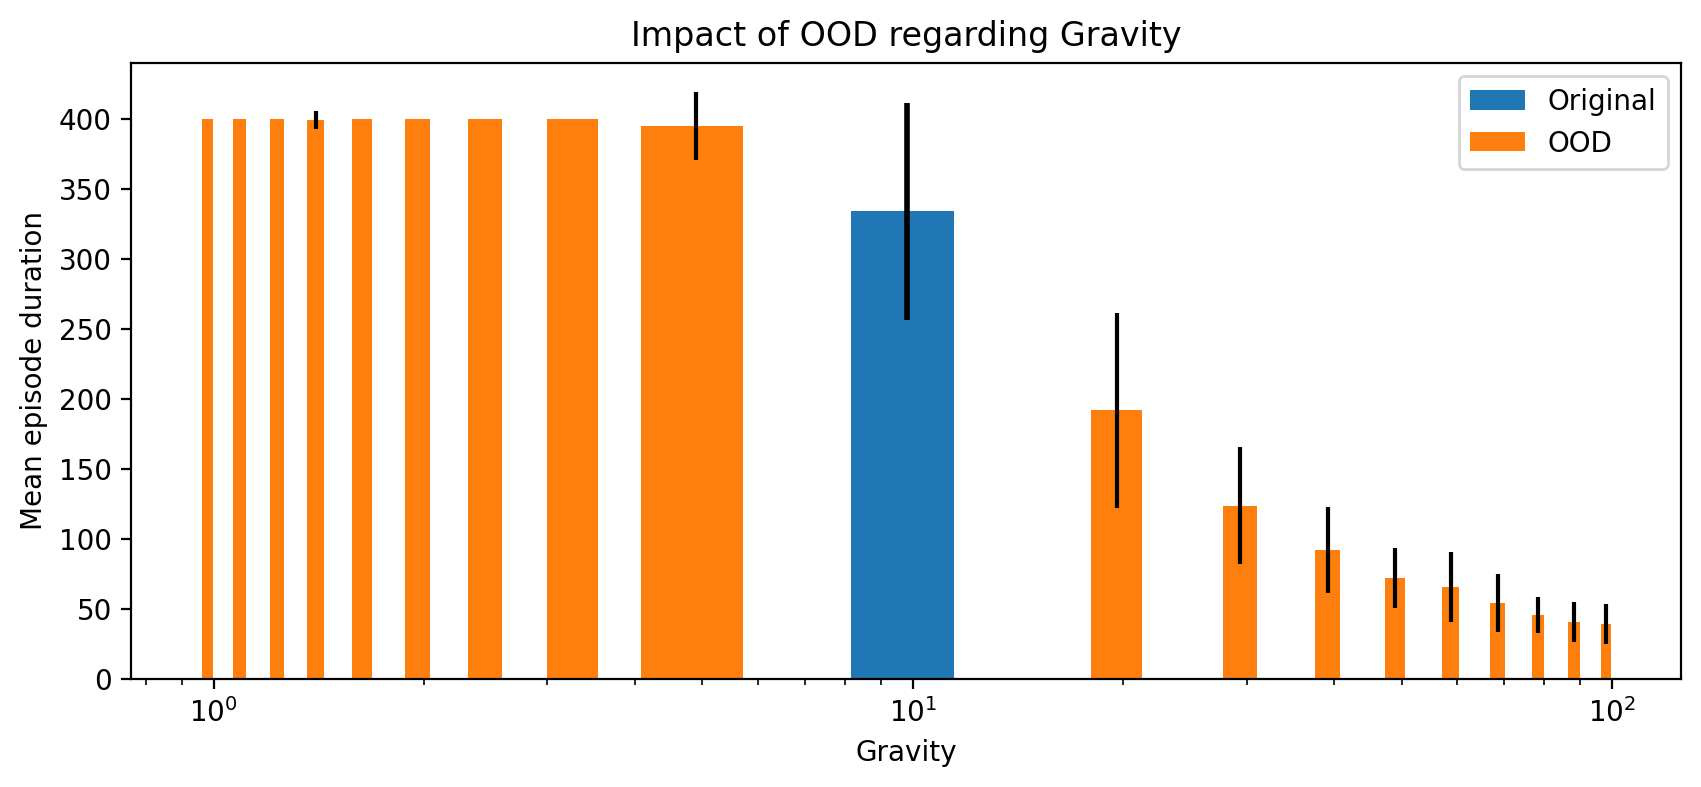

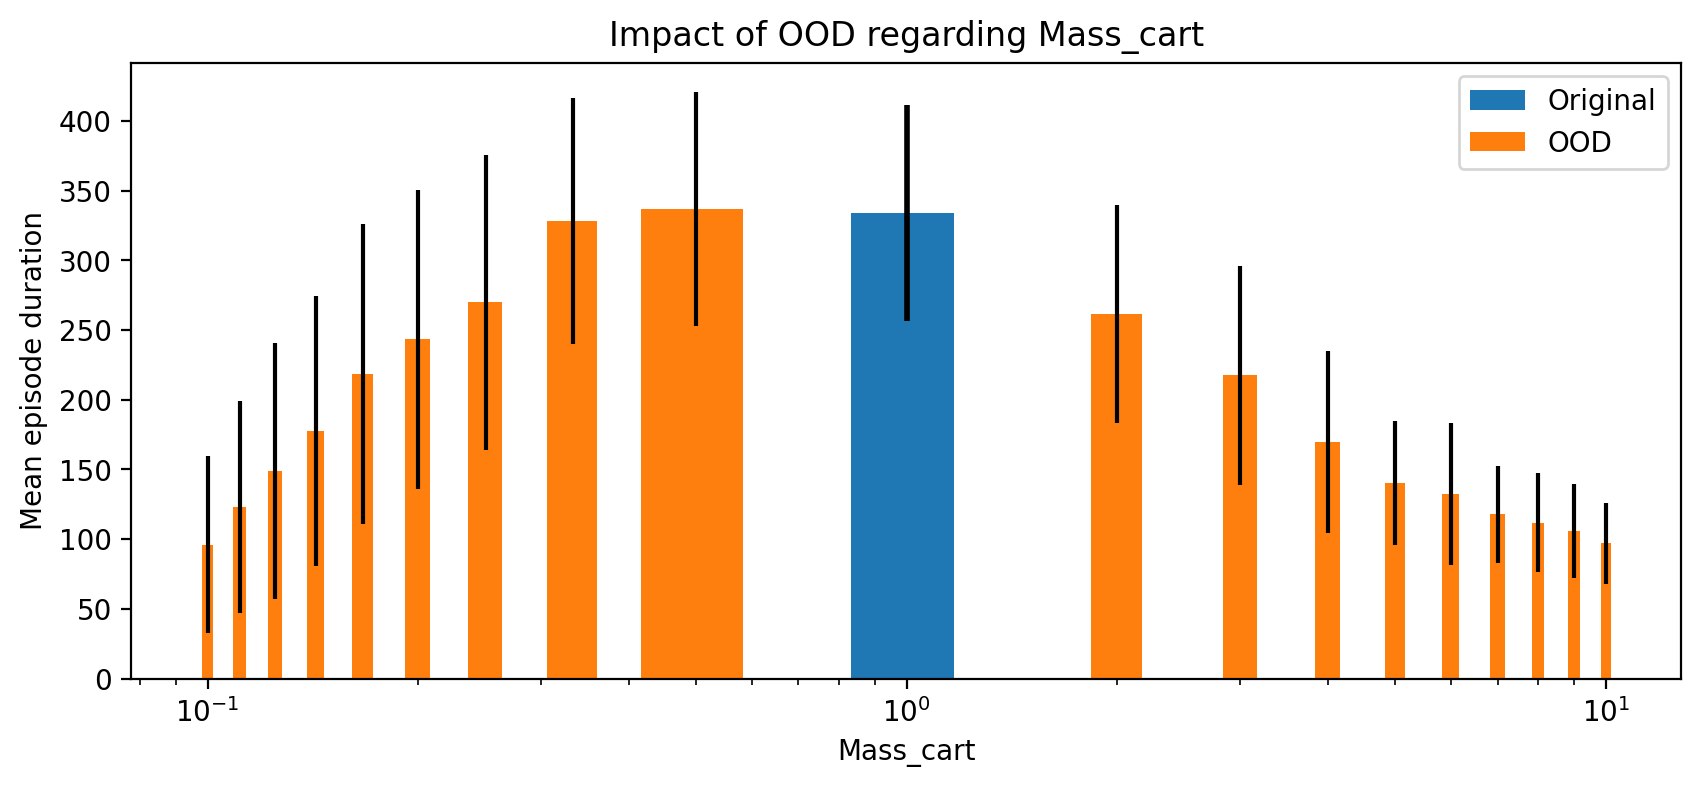

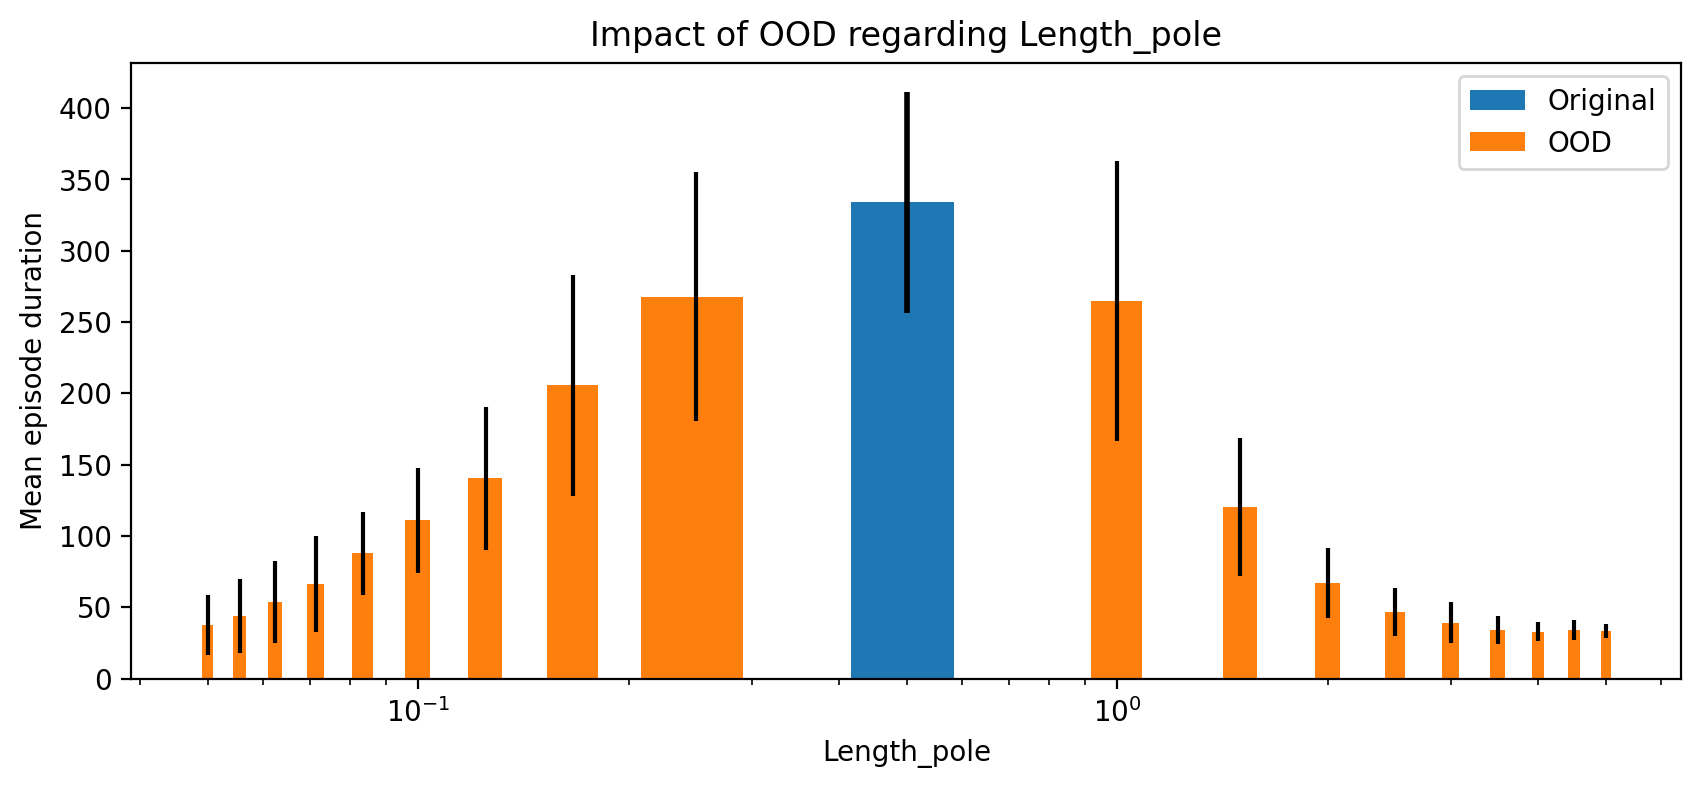

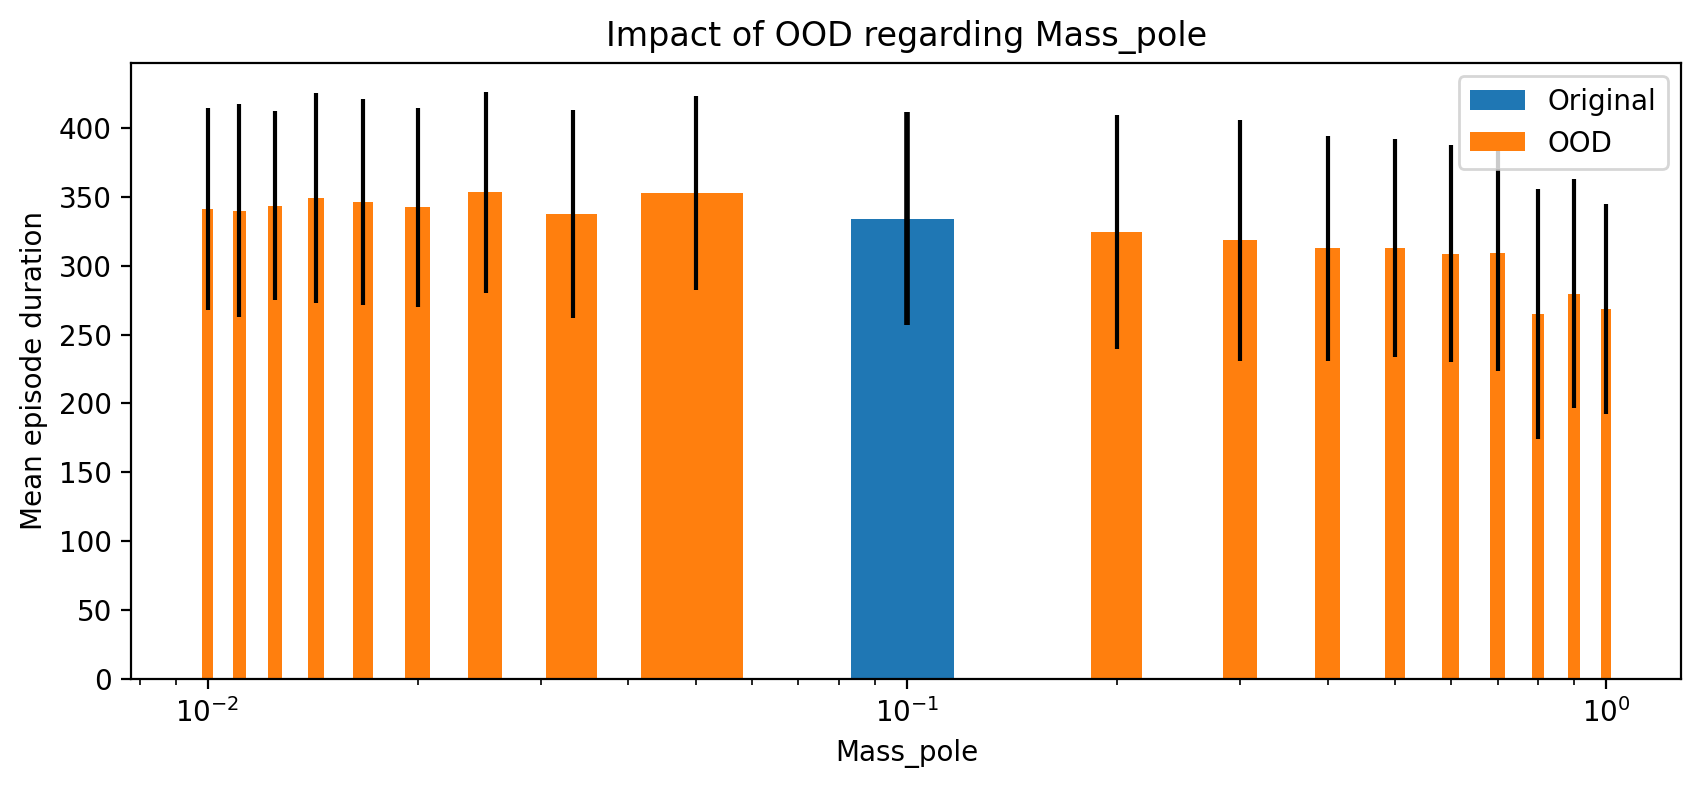

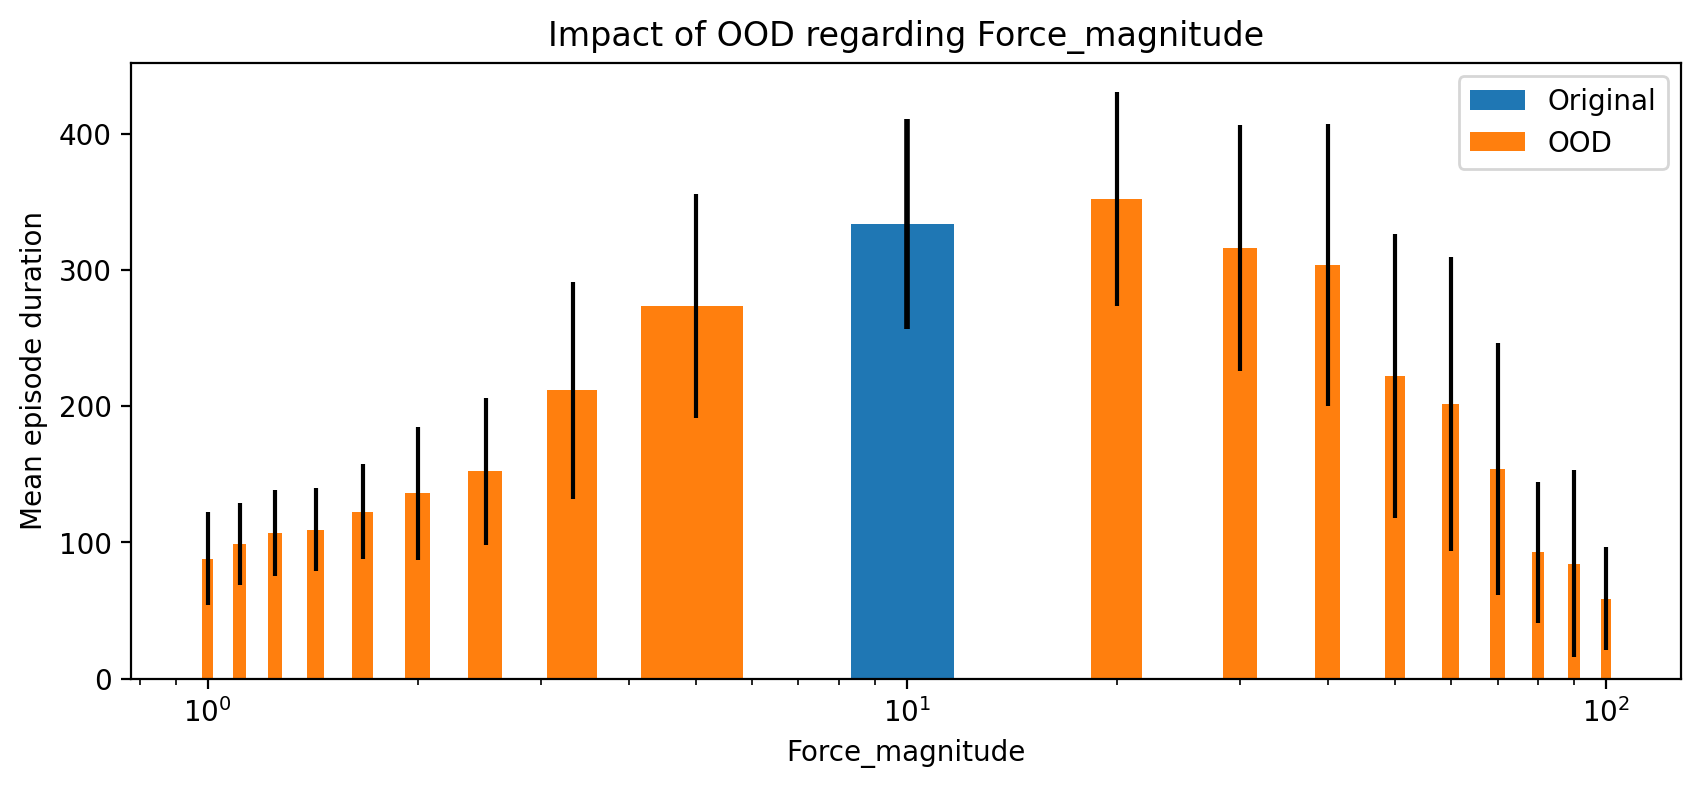

In [45]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array(labels[1:]) - np.array(labels[:-1]) 
    width /= 3
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)
    ax.bar(default_values[key], original_result, yerr=original_std_result, width=width, label='Original')

    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    """
    ax.bar(str(default_values[key]), original_result, width=width)
    labels = [str(x) for x in values[key]]
    ax.bar(labels, results[key], width=width)
    """
    

In [46]:
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

In [47]:
evaluate(env, agent)

(327.08, 86.17327660011541)

In [78]:
def normalize(x, limits):
    """low, high = limits
    norm_x = (x - low)/(high - low)
    norm_x = (norm_x-0.5)*2.0
    assert torch.all(torch.abs(norm_x) <= 1.0)
    return norm_x"""
    return x

def denormalize(x, limits):
    """x = 0.5*x+0.5
    low, high = limits
    return x * (high - low) + low"""
    return x

class MLP(nn.Module):

    def __init__(self, input_size, output_size, size_hidden_layers, bias=True, final_activation=None, dropout=0.1):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.size_hidden_layers = size_hidden_layers

        layer = []
        previous_input_size = input_size
        for size_hidden_layer in size_hidden_layers:
            layer.append(nn.Linear(previous_input_size, size_hidden_layer, bias=bias))
            layer.append(nn.ReLU())
            layer.append(torch.nn.Dropout(dropout))
            previous_input_size = size_hidden_layer

        layer.append(nn.Linear(previous_input_size, output_size, bias=False))

        if final_activation is not None:
            layer.append(final_activation)

        

        self.net = nn.Sequential(*layer)

    def forward(self, X):   
        if not torch.is_tensor(X):  
            X = torch.tensor(X)
        X = X.reshape(-1, self.input_size)
        return self.net(X)
    
    

In [79]:
def get_space_limits(space):
    if isinstance(space, gym.spaces.Discrete):
        return np.array([0.0], dtype=np.float32),  np.array([float(env.action_space.n -1)], dtype=np.float32)
    else:
        return space.low, space.high

In [80]:
class Memory(gym.Wrapper):
    def __init__(self, env, size, verbose=False, *args, **kwargs):
        super().__init__(env, *args, **kwargs)
        self.size = size
        self.verbose = verbose
        
        self.obs_limits = get_space_limits(env.observation_space)  
        self.act_limits = get_space_limits(env.action_space)
        
        self.state_size = self.obs_limits[0].shape[0]
        self.action_size = self.act_limits[0].shape[0]
       
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        
        self.history_obs = np.roll(self.history_obs, -self.state_size)
        self.history_obs[-1] = obs
        
        self.history_action = np.roll(self.history_action, -self.action_size)
        self.history_action[-1] = action

        if self.verbose:
            print(self.history_obs)
            print(self.history_action)
        
        return obs, reward, done, info

    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        self.history_obs = np.full((self.size, self.state_size), observation)
        self.history_action = np.full((self.size, self.action_size), 0)
        return observation
        

    def get_history(self, concat=False):
        if concat:
            return np.concatenate((self.history_obs, self.history_action), axis=1)
        else:
            return self.history_obs, self.history_action
    
    


In [81]:
env = instanciate_cartpole(default_values)
mem_env = Memory(env, 5)

In [82]:
mem_env.reset()
mem_env.step(0)
mem_env.get_history(True)

array([[ 0.01119173,  0.03644659,  0.00562512,  0.01346633,  0.        ],
       [ 0.01119173,  0.03644659,  0.00562512,  0.01346633,  0.        ],
       [ 0.01119173,  0.03644659,  0.00562512,  0.01346633,  0.        ],
       [ 0.01119173,  0.03644659,  0.00562512,  0.01346633,  0.        ],
       [ 0.01192066, -0.15875557,  0.00589445,  0.30791873,  0.        ]])

In [83]:
env

<TimeLimit<CartPoleEnv<CartPole-v1>>>

In [84]:
env.reset()

array([ 0.03371347, -0.02793292, -0.0382028 , -0.03894635], dtype=float32)

In [ ]:


class GaussianModel():
    def __init__(self, env, size_hidden_layers=[1000, 500], size_memory=5, confidence=True, dropout=0.1) -> None:
        self.size_memory = size_memory
        
        self.obs_limits = get_space_limits(env.observation_space)  
        self.act_limits = get_space_limits(env.action_space)
        
        self.state_size = self.obs_limits[0].shape[0]
        self.action_size = self.act_limits[0].shape[0]
        
        input_size, output_size = size_memory*(self.state_size + self.action_size), self.state_size
        
        self.pred_model = MLP(input_size, output_size, size_hidden_layers, bias=True, final_activation=None, dropout=dropout)
        
        self.confidence = confidence
        if self.confidence:
            # nn.LeakyReLU has the advantage to have a symetrical derivative in any point excpet 0.
            # using for example the Softplus function would bias the variance estimation, and be problematic with the test
            self.conf_model = MLP(input_size, output_size, size_hidden_layers=[500, 100], bias=True, final_activation=nn.LeakyReLU(-1.0), dropout=dropout)

        #self.history_size = history_size
        self.criterion = nn.MSELoss()

    def predict_diff_states(self, history):
        X = torch.tensor(history).reshape(self.size_memory*(self.state_size+self.action_size)).float()  

        X.requires_grad = True
        pred_diff = self.pred_model(X) #.detach() 
        
        if self.confidence:
            std = self.conf_model(X) #.detach()
        else:
            std = torch.ones(pred_diff.shape).to(device)
        
        return pred_diff[0], std[0]

    def save(self, folder):
        os.makedirs(folder, exist_ok=True)
        torch.save(self.pred_model.cpu(), folder / 'pred_model.pth')
        if self.confidence:
            torch.save(self.conf_model.cpu(), folder / 'conf_model.pth')
        #joblib.dump(self.scaler_X, folder / 'scaler_X.bin', compress=True)
        #joblib.dump(self.scaler_Y, folder / 'scaler_Y.bin', compress=True)

    def load(self, folder):
        self.pred_model = torch.load(folder / 'pred_model.pth').to(device)
        if self.confidence:
            self.conf_model = torch.load(folder / 'conf_model.pth').to(device)
        #self.scaler_X = joblib.load(folder / 'scaler_X.bin')
        #self.scaler_Y = joblib.load(folder / 'scaler_Y.bin')


    def fit(self, env, nb_steps = 1000, num_epochs=25, lr :float =0.1):
        
        env = Memory(env, self.size_memory)
        models = {'pred':self.pred_model}
        if self.confidence:
            models['conf'] = self.conf_model
  
        for model_type, model in models.items():
            print('Fitting '+model_type+' : ' + str(model))
            model.train()

            # Observe that all parameters are being optimized
            optimizer = torch.optim.Adam(model.parameters(), lr)

            # Decay LR by a factor of 0.1 every 7 epochs
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            writer = SummaryWriter('tensorboard/model_learning_'+model_type)
            since = time.time()

            best_loss = 1e10

            pbar = trange(num_epochs)
            for epoch in pbar:
                #print(f'Epoch {epoch}/{num_epochs - 1}')
                #print('-' * 10)

                # Each epoch has a training and validation phase
                phase_loss = {}
                    
                observation = env.reset()
                running_loss = 0.0
                
                for t in range(nb_steps):
                    #action, _state = agent.predict(observation)
                    action = env.action_space.sample()
                    previous_obs = observation
                    observation, reward, terminated, info = env.step(action)
                    history = env.get_history(True)
                    
                    observation = torch.FloatTensor(observation).reshape(self.state_size)     
                    #history = torch.FloatTensor(history).reshape(self.size_memory*self.state_size)     
                    #env.render()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        #print('inputs: ', inputs.shape)
                        #gap = (observation - previous_obs - pred_diff)/std
                        pred_diff, std = self.predict_diff_states(history)

                        if model_type == 'conf':
                            #print(observation, previous_obs, pred_diff)
                            loss = self.criterion(torch.abs(observation - previous_obs - pred_diff.detach()), std)
                            #loss = self.criterion((outputs - labels)**2, vari)
                        else:
                            loss = self.criterion((observation - previous_obs - pred_diff), torch.zeros(1)) #/std.detach()

                        loss.backward()
                        optimizer.step()

                        # statistics
                        running_loss += loss.item()
                        
                    if terminated:
                        observation = env.reset()
                        
                    
                scheduler.step()

                epoch_loss = running_loss / nb_steps
                    #print(f'{phase} Loss: {epoch_loss:.4f}')
                    #print()

                    # deep copy the model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss

                writer.add_scalar(model_type+' Loss', epoch_loss, epoch)
                writer.flush()
                
                pbar.set_description("Loss: %2.4f" % (epoch_loss))

            time_elapsed = time.time() - since
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Loss: {best_loss:4f}')

            
            model.eval()
            
        return best_loss

    def visualize(self, env, steps=100, saving_path=Path.cwd() / 'Plots', plot=True, render=False, figsize=(10, 4), dpi=300):
        env = Memory(env, self.size_memory)
        os.makedirs(saving_path, exist_ok=True)
        writer = SummaryWriter('tensorboard/visualize_model')
        
        self.pred_model = self.pred_model.to(device).eval()
        if self.confidence:
            self.conf_model = self.conf_model.to(device).eval()
        
        observations = []
        actions = []
        pred_diffs = []
        real_diffs = []
        pred_stds = []

        done=True

        if plot:
            pbar = trange(steps)
        else:
            pbar = range(steps)

        observation = torch.FloatTensor(env.reset()).reshape(self.state_size)     
        running_loss = 0.0

        for t in pbar:
            #action, _state = agent.predict(observation)
            action = env.action_space.sample()
            previous_obs = observation
            observation, reward, terminated, info = env.step(action)
            
            history = env.get_history(True)
            
            observation = torch.FloatTensor(observation).reshape(self.state_size)  
            if render:
                env.render()


            #print('inputs: ', inputs.shape)
            #gap = (observation - previous_obs - pred_diff)/std
            pred_diff, std = self.predict_diff_states(history)
            #pred_diff, std = self.predict_diff_states(previous_obs, action)
            pred_diff, std = pred_diff.detach(), std.detach()


            loss_conf = self.criterion(torch.abs(observation - previous_obs - pred_diff), std)

            loss_pred = self.criterion((observation - previous_obs - pred_diff)/std, torch.zeros(1))

            # statistics
            #running_loss += loss.item()

            if terminated:
                observation = env.reset()

            if plot:
                pbar.set_description("loss_pred: %2.4f, loss_conf: %2.4f" % (loss_pred, loss_conf))



            #print(f'{phase} Loss: {epoch_loss:.4f}')
            #print()
            #writer.add_scalars('run_14h', {'xsinx':np.sin(t), 'xcosx':np.cos(t), 'tanx': np.tan(t)}, t)
            for state_id in range(self.state_size):
                writer.add_scalar('observation/'+str(state_id), np.array(observation)[state_id], t)
                d =  {'predicted': np.array(pred_diff)[state_id], 'real': (np.array(observation) - np.array(previous_obs))[state_id]}

                writer.add_scalars('observation_difference/'+str(state_id),d, t)
                
                writer.add_scalar('observation_std/'+str(state_id), np.array(std)[state_id], t)

            for action_id in range(self.action_size):
                writer.add_scalar('action/'+str(action_id), np.array(action).reshape(self.action_size)[action_id], t)
                
            writer.flush()
            
            observations.append(np.array(observation)) #.numpy()
            actions.append(np.array(action).reshape(self.action_size))
            pred_diffs.append(np.array(pred_diff))
            real_diffs.append(np.array(observation) - np.array(previous_obs))
            pred_stds.append(np.array(std))

            """writer.add_scalar('state/'+str(state_id), distance.numpy(), i)
            writer.add_scalar('state/speed', speed.numpy(), i)
            writer.add_scalar('action', action.numpy(), i)
            writer.add_scalar('diff_distances/prediction', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/reality', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/variance', var_distance.numpy(), i)

            writer.add_scalar('diff_speed/prediction', pred_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/reality', real_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/variance', var_speed.numpy(), i)
            writer.flush()"""
            
        observations = np.array(observations)
        actions = np.array(actions)
        pred_diffs = np.array(pred_diffs)
        real_diffs = np.array(real_diffs)
        pred_stds = np.array(pred_stds)
        
        for state_id in range(self.state_size):
            

            evolution = {}
            evolution['prediction'] = np.array(pred_diffs[:,state_id])
            evolution['reality'] = np.array(real_diffs[:,state_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of observation component ' + str(state_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_diff_obs', bbox_inches='tight')
                plt.show()
                
        for state_id in range(self.state_size):
            

            evolution = {}
            evolution['prediction'] = np.array(pred_diffs[:,state_id]) + observations
            evolution['reality'] = np.array(real_diffs[:,state_id]) + observations
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of observation component ' + str(state_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_diff_obs', bbox_inches='tight')
                plt.show()

        for action_id in range(self.action_size):
            
            evolution = {}
            evolution['prediction'] = np.array(actions[:,action_id])
            evolution['reality'] = np.array(actions[:,action_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of action component ' + str(action_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_act', bbox_inches='tight')
                plt.show()

        

        """
        error_diff_distances = diff_distance_dict['prediction'] - diff_distance_dict['reality']
        if plot:
            plot_error_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, unit='m')
            plot_error_corrected(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi, unit='m')

        error_diff_speeds = diff_speed_dict['prediction'] - diff_speed_dict['reality']
        if plot:
            plot_error_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, unit='m/s')
            plot_error_corrected(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi, unit='m/s')
        """
        return observations, actions, pred_diffs, real_diffs, pred_stds


In [33]:
model = GaussianModel(env, confidence=False, size_memory=10, size_hidden_layers=[1000, 800, 500, 300, 100], dropout=0.0)
model.fit(env, nb_steps=1000, lr=0.001)
model.save(path / 'saved_models' / 'no_confidence')

Fitting pred : MLP(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=1000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=1000, out_features=800, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=800, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=500, out_features=300, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.0, inplace=False)
    (12): Linear(in_features=300, out_features=100, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.0, inplace=False)
    (15): Linear(in_features=100, out_features=4, bias=False)
  )
)


  0%|                                                    | 0/25 [00:00<?, ?it/s]/Users/gardille/miniforge3/envs/rl_ood_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss: 0.0000: 100%|█████████████████████████████| 25/25 [01:56<00:00,  4.66s/it]

Training complete in 1m 56s
Best val Loss: 0.000005


loss_pred: 0.0000, loss_conf: 0.9917: 100%|██| 100/100 [00:00<00:00, 315.96it/s]


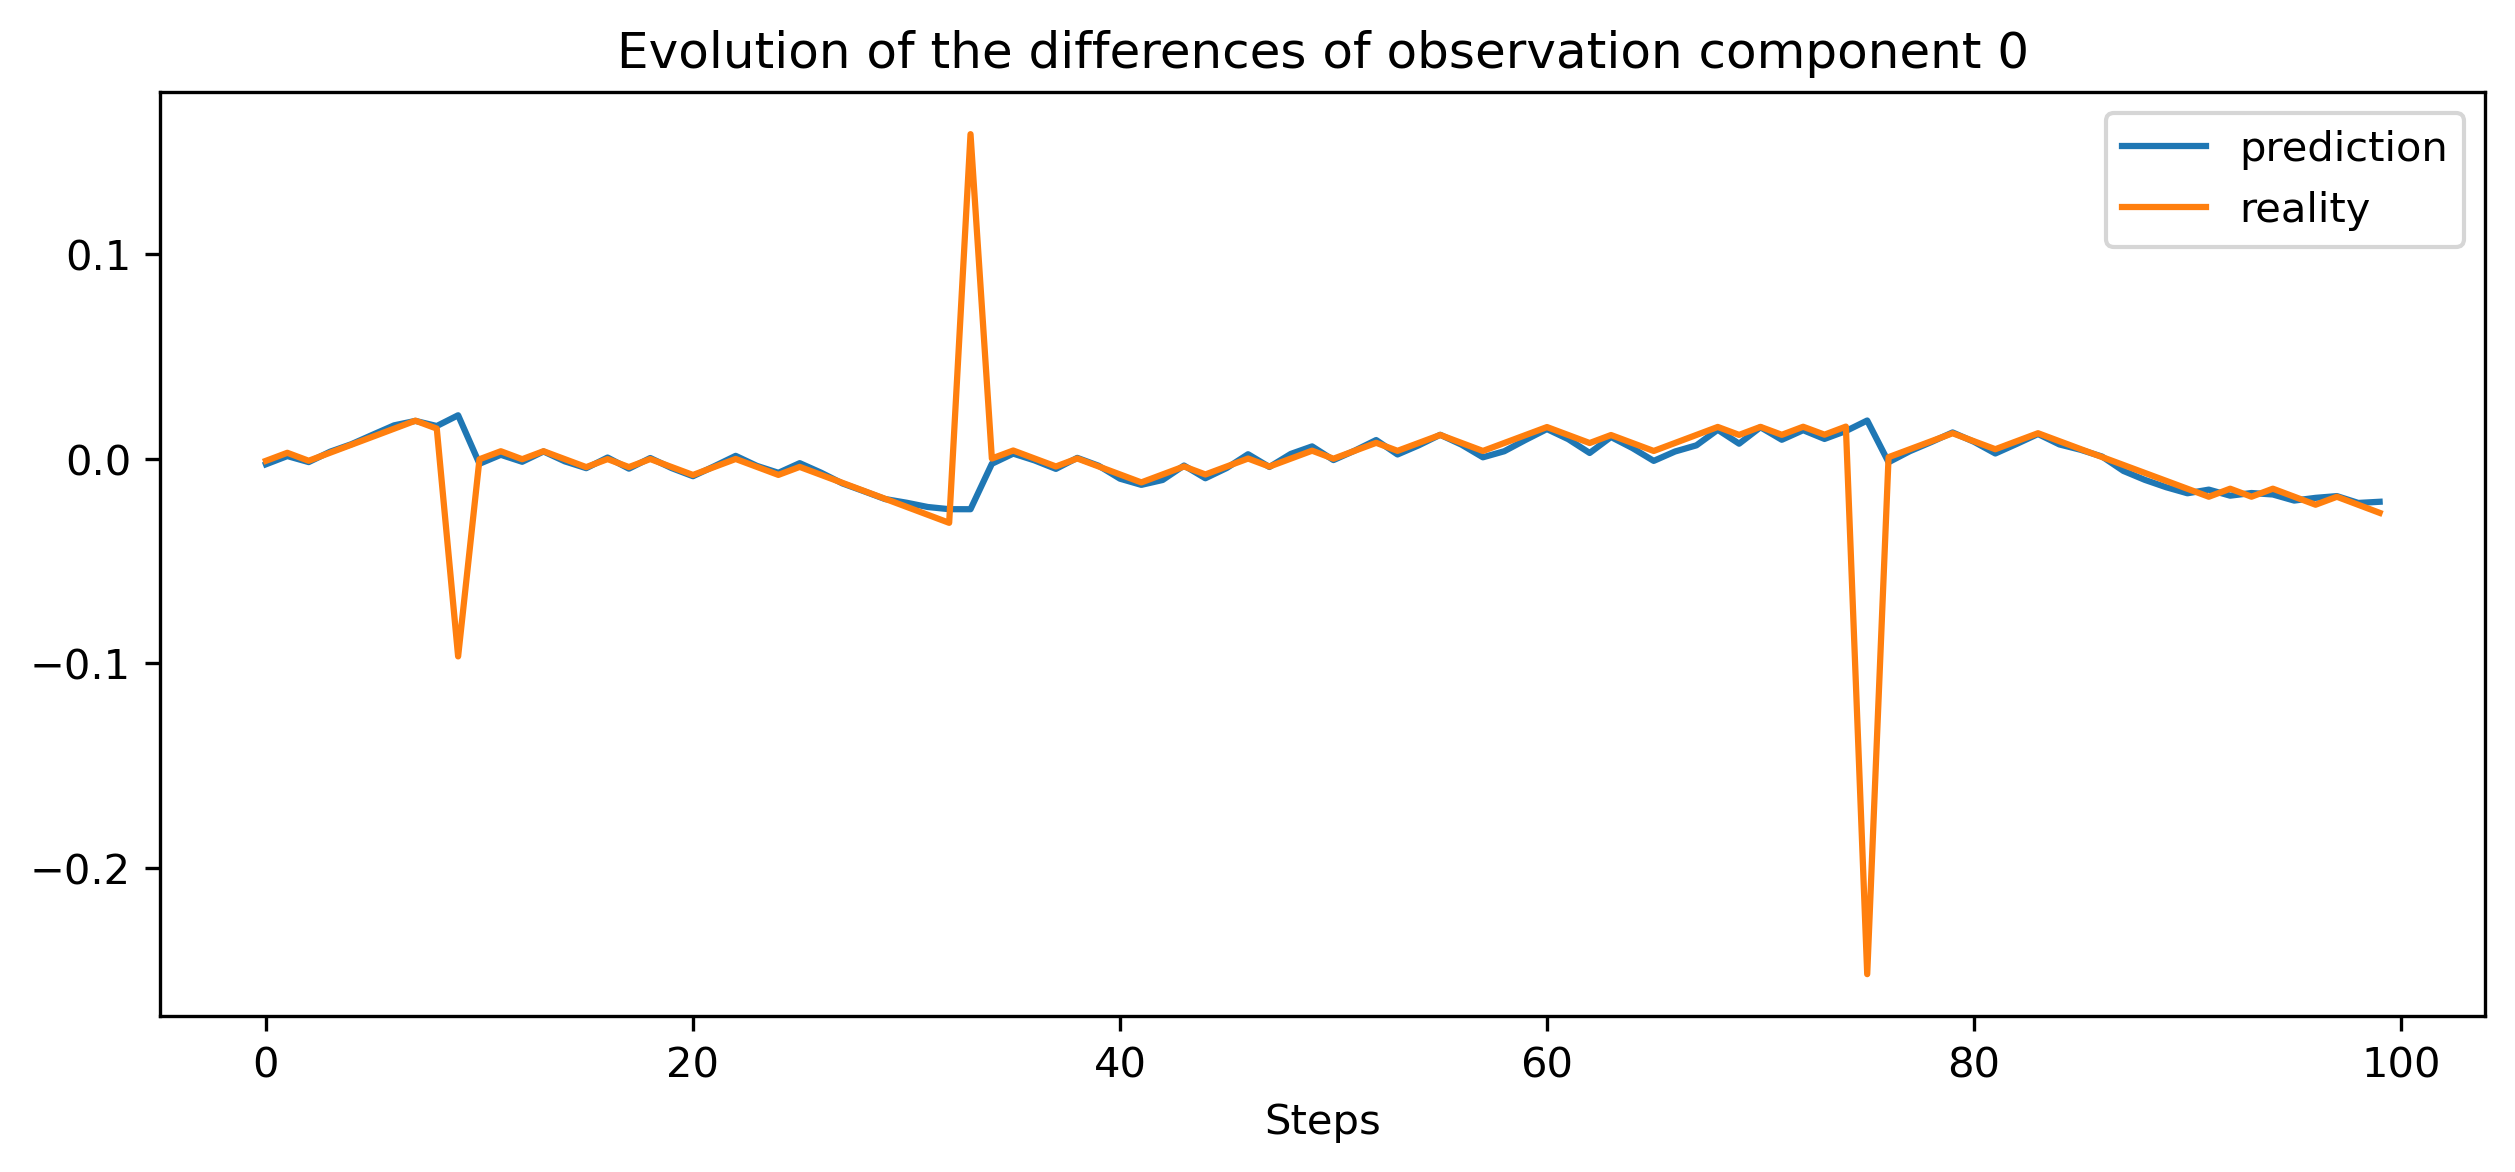

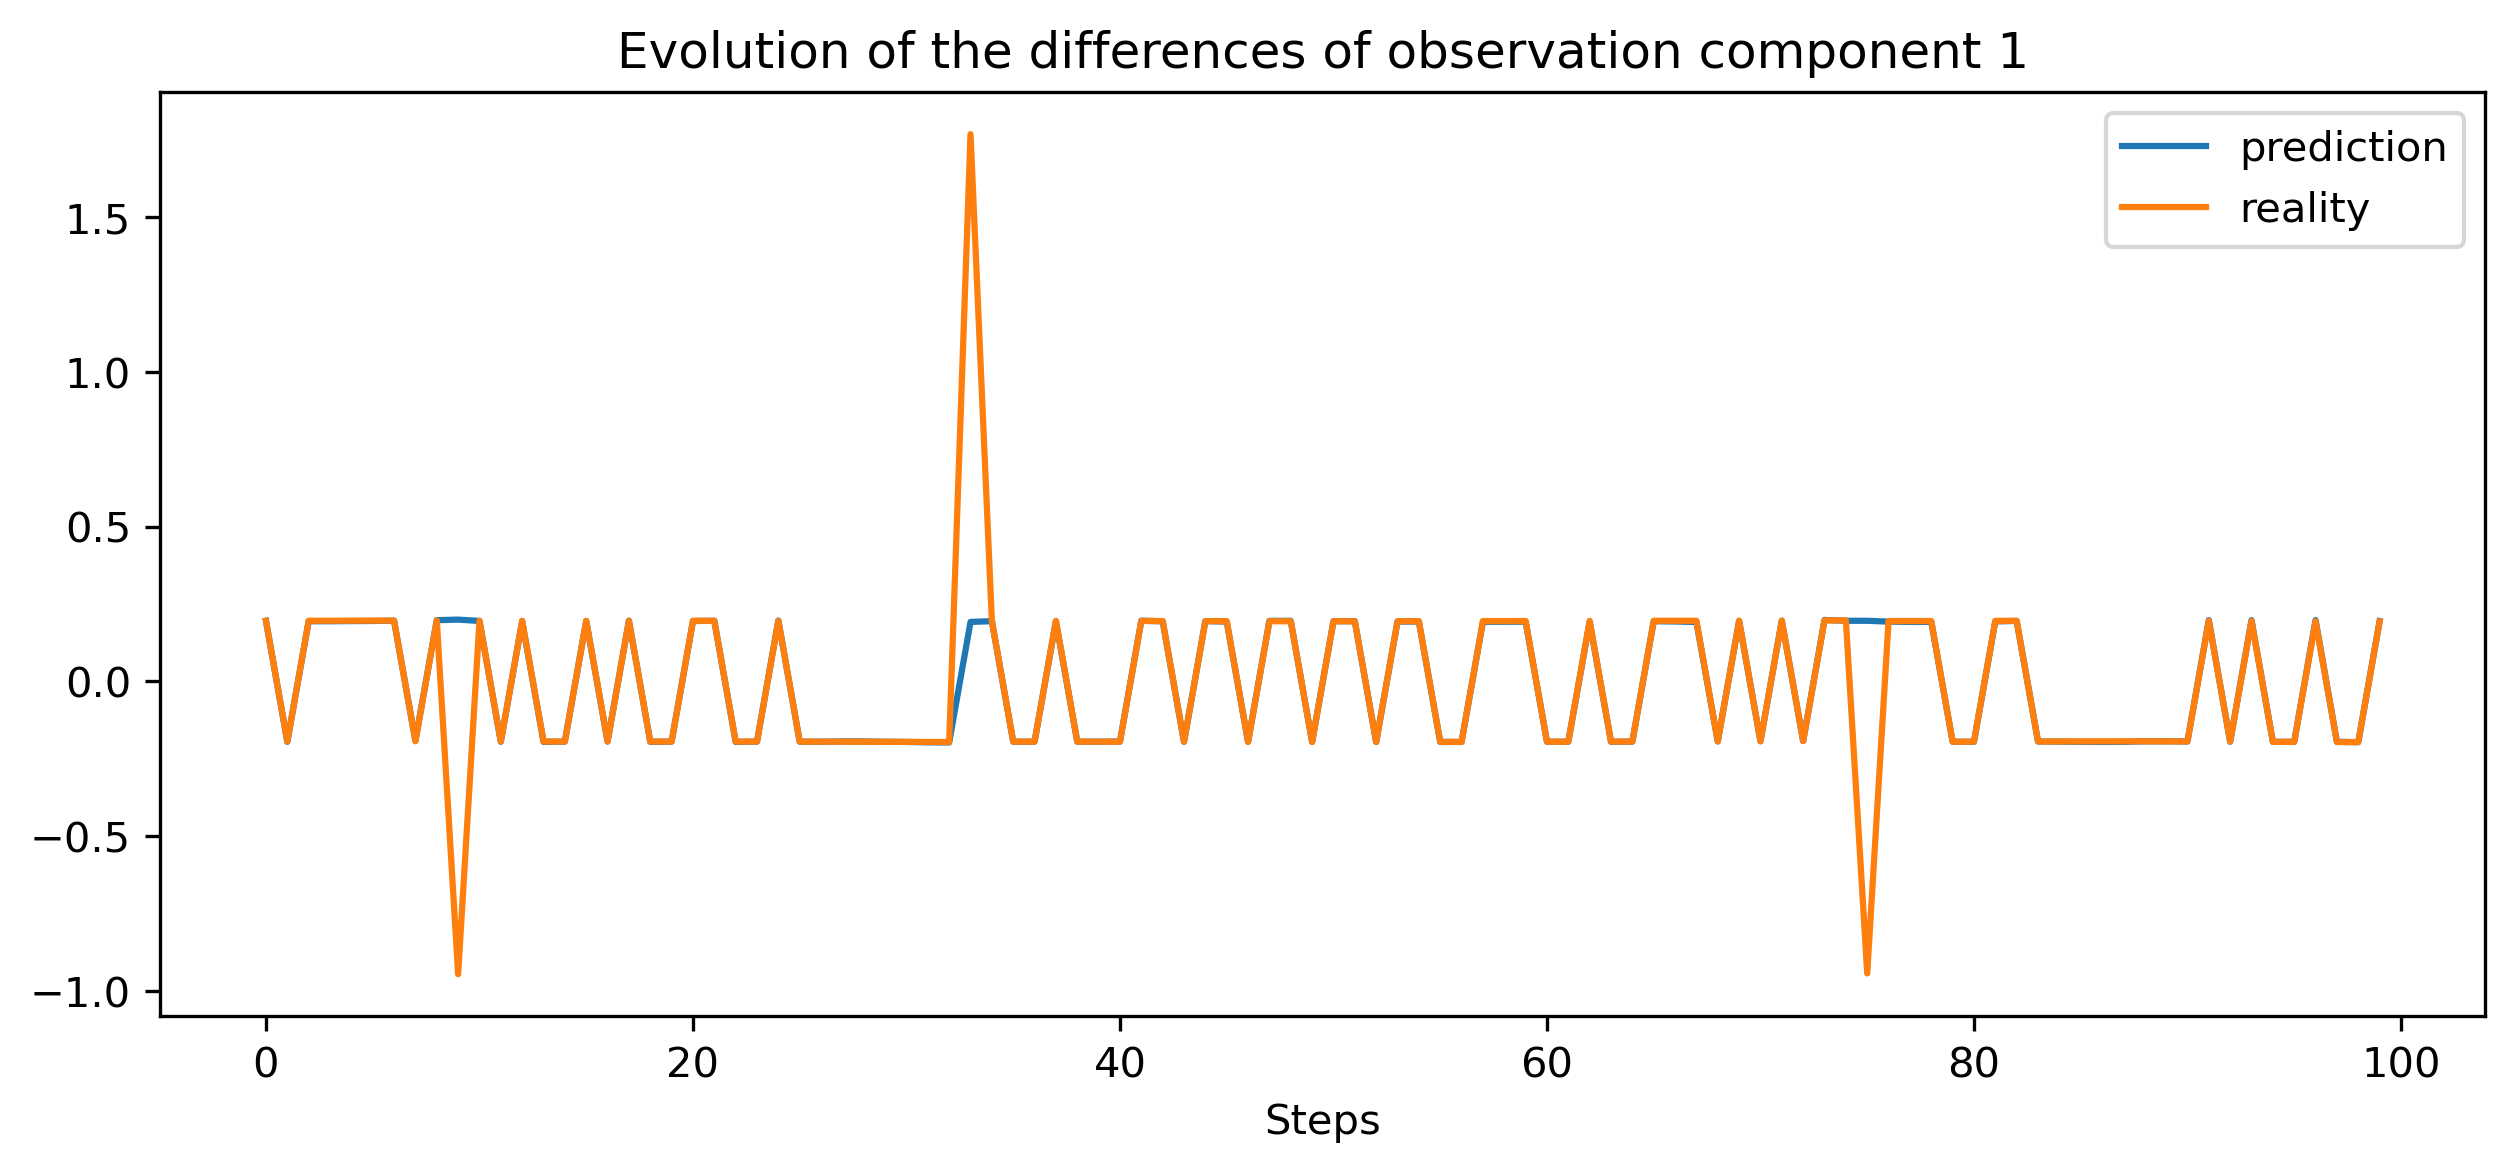

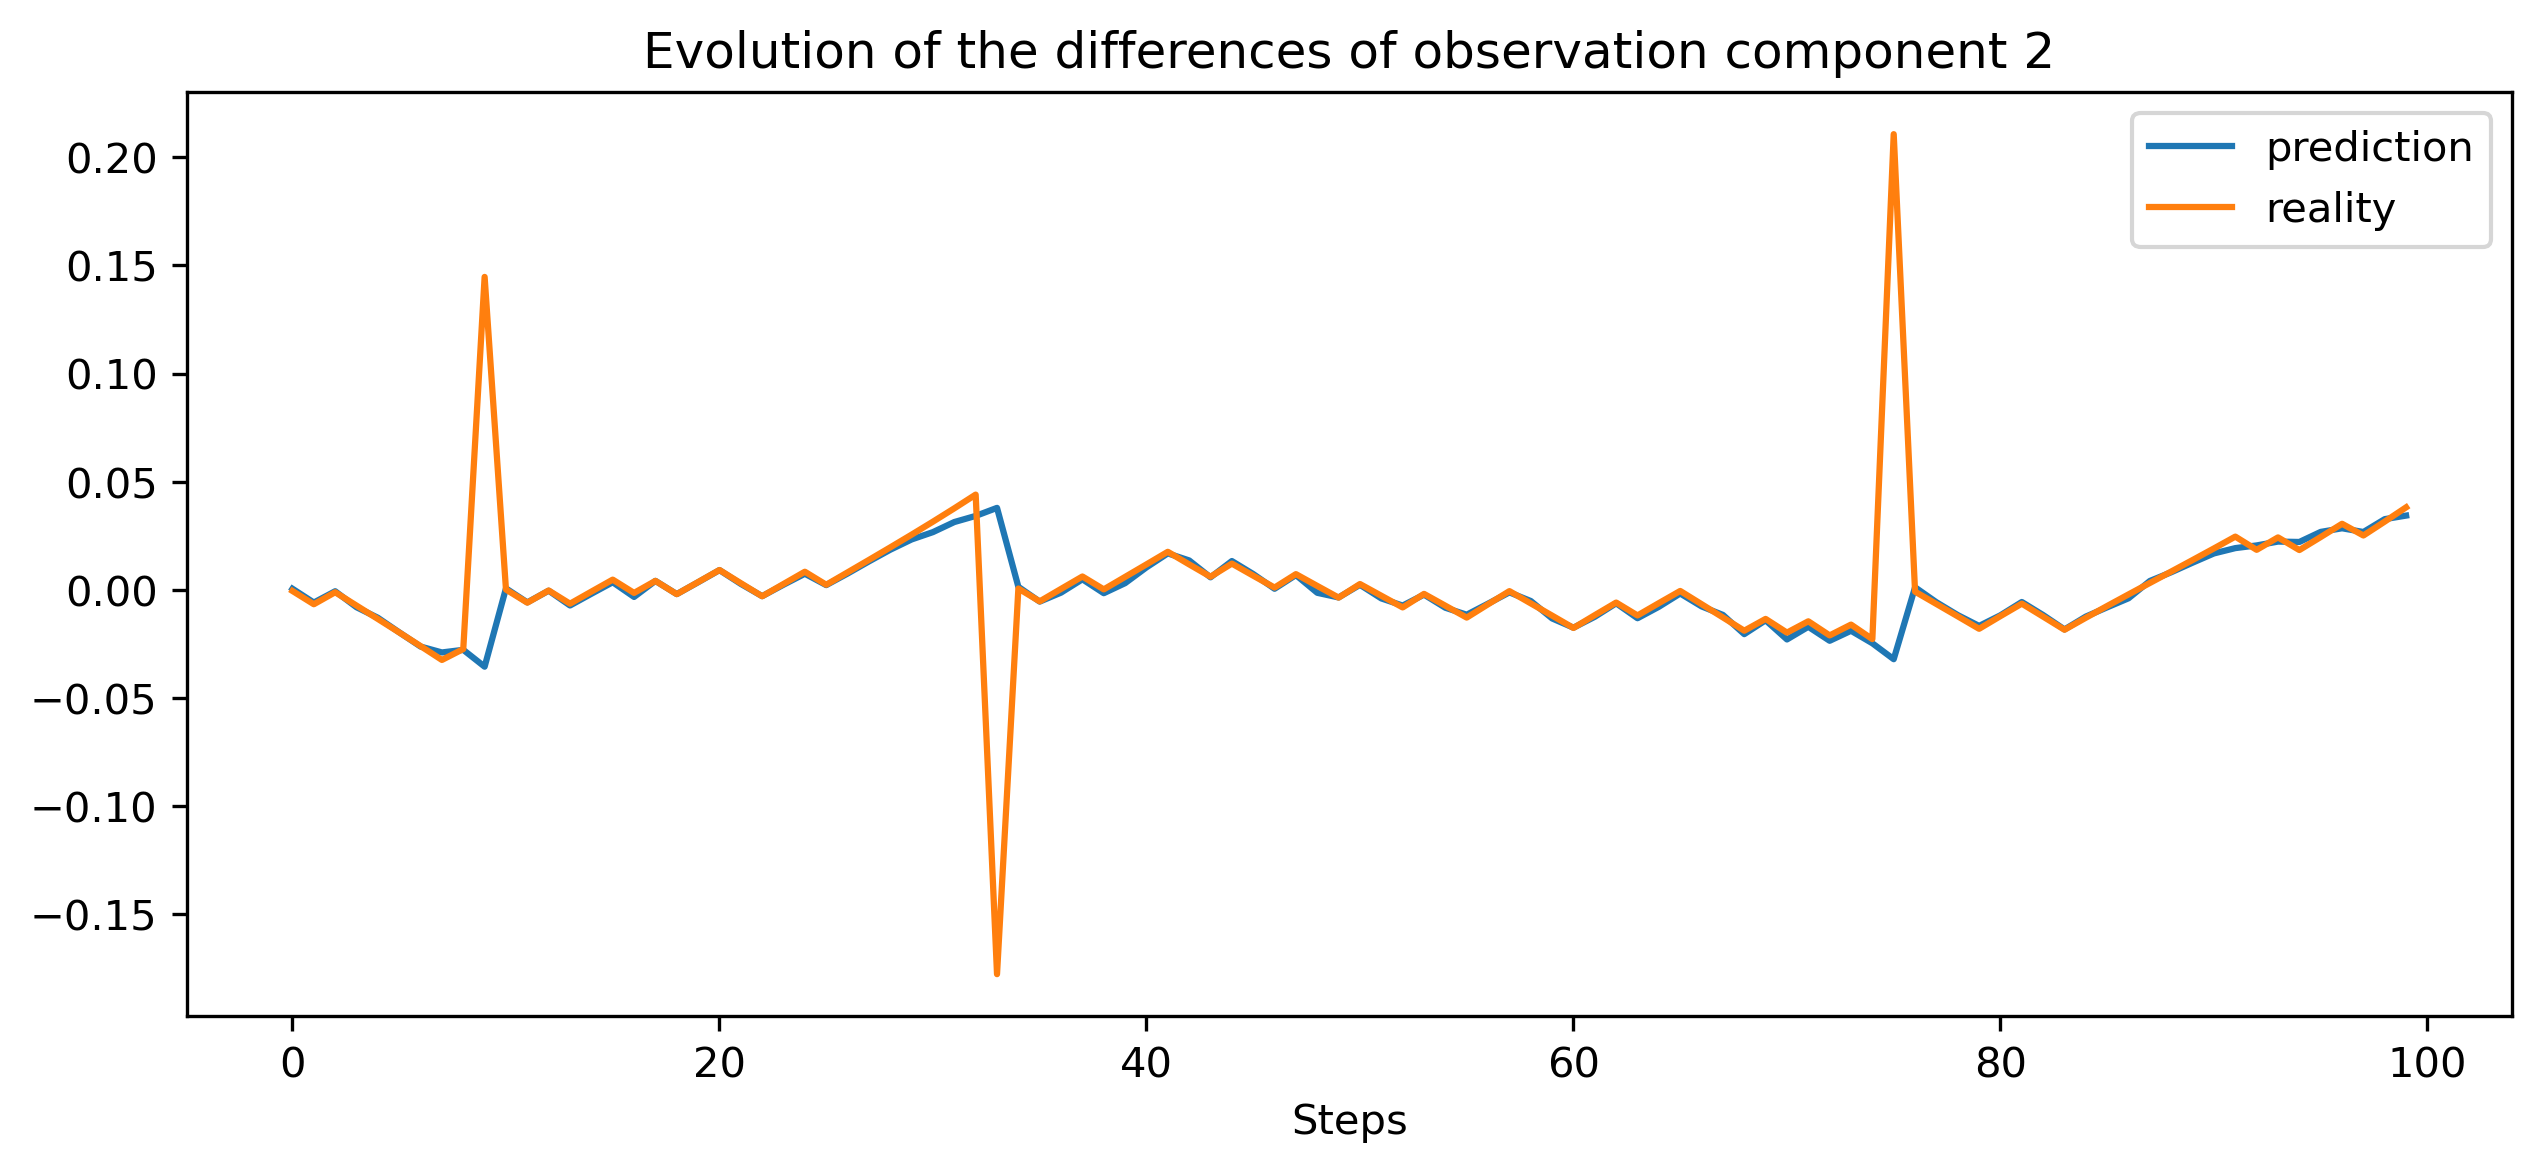

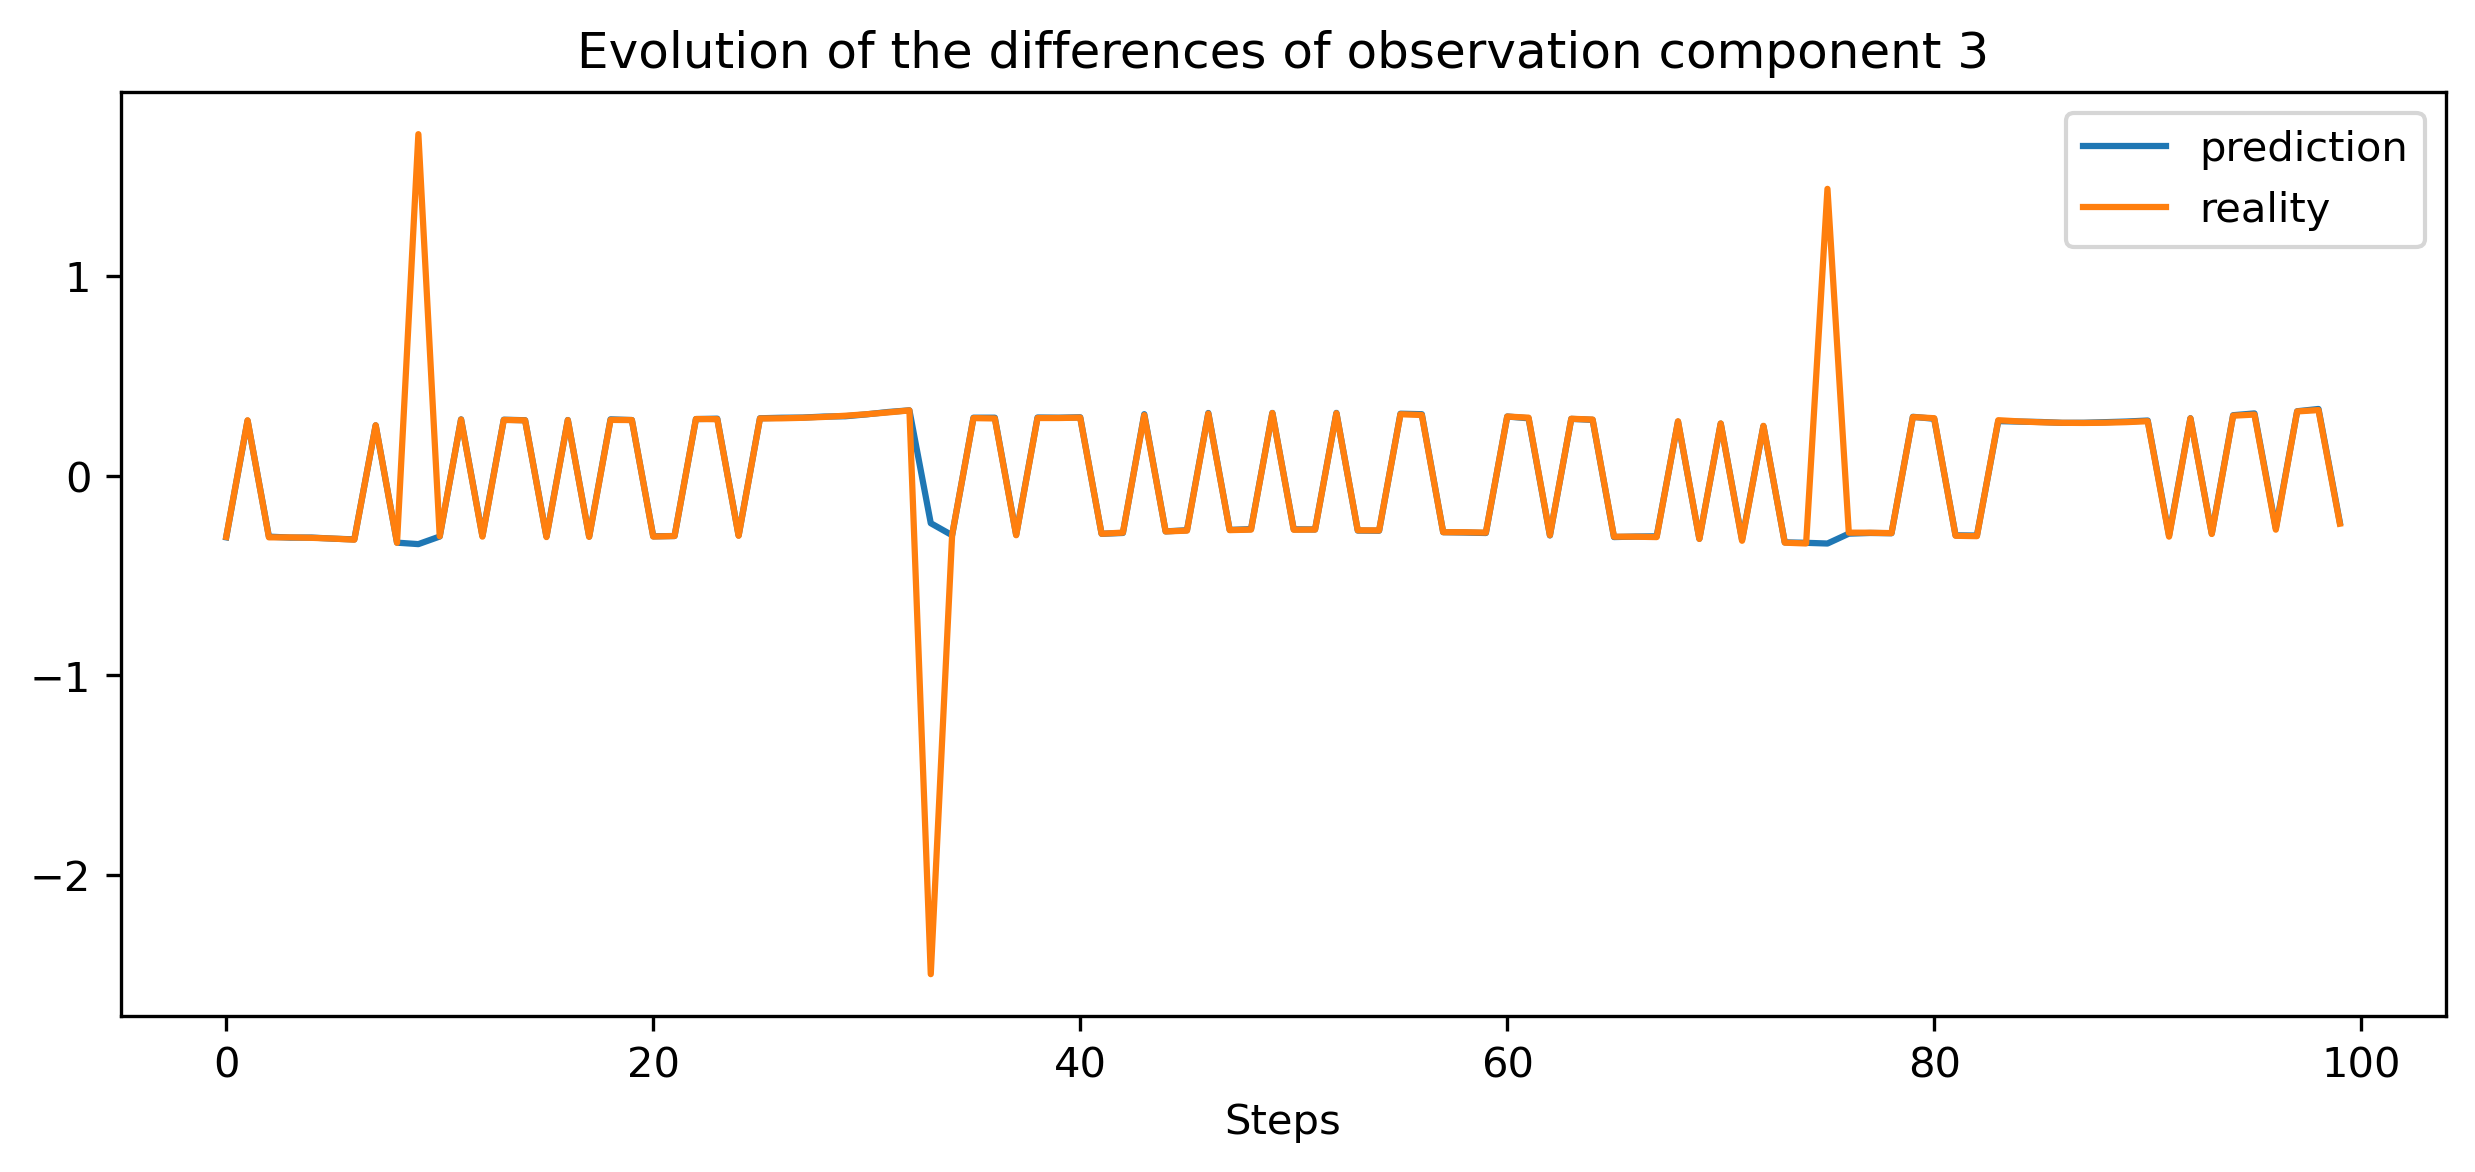

ValueError: operands could not be broadcast together with shapes (100,) (100,4) 

In [34]:
model.visualize(env, steps=100)
0

In [ ]:
model = GaussianModel(env, confidence=True, dropout=0.0)
#model.confidence = False
model.fit(env, nb_steps=10000, lr=0.001)
model.save(path / 'saved_models' / 'with_confidence')

In [ ]:
#model.fit(env, nb_steps=1000, lr=0.001)

In [ ]:
#model.load(path / 'saved_models' / 'with_confidence')
model.visualize(env, steps=100)
0

In [ ]:
from scipy import stats

def z_test(X):
    X = np.array(X)
    # X est suppose de variance 1, et on test si son esperance est de 0
    #print('Variance: ', np.var(X))
    if len(X.shape) > 1:
        return np.array([z_test(X[:,i]) for i in range(X.shape[1])])

    n = len(X)
    X = X / np.std(X)
    t = - np.abs(X.mean() * np.sqrt(n))
    p_value = 2.0 * stats.norm.cdf(t)
    return p_value

In [ ]:
class OODDetector(gym.Wrapper):
    """
    OOD is detected when the model error is biased. 
    This bias is detected through a T-test over the last memory_len errors. 
    """
    def __init__(self, env: gym.Env, model :GaussianModel, memory_len=100, verbose=True, intervention_name='None', *args, **kwargs) -> None:
        super().__init__(env, *args, **kwargs)
        self.env = Memory(env, model.size_memory)
        self.model = model
        self.index = 0
        self.state_size = model.state_size

        self.statistic_threshold = 1.0
        self.pvalue_threshold = 0.2
        self.intervention_name = intervention_name

        self.previous_obs = env.reset()
        self.writer = SummaryWriter('tensorboard/ood_detection/' + intervention_name)

    def compute_gap(self, obs, act):
        """
        Compute the model's relative error, by comparing its predictions to the reality.
        """
        pred_diff, std = self.model.predict_diff_states(self.env.get_history(True))
        pred_diff, std = pred_diff.detach().numpy(), std.detach().numpy()
        
        
        real_diff = (obs - self.previous_obs)
        relative_gap = (pred_diff - real_diff)/std
        #print(pred_diff, real_diff, std, relative_gap)
        return relative_gap


    def step(self, action, *args, **kwargs):
        
        obs, reward, done, info = self.env.step(action, *args, **kwargs)

        relative_gap = self.compute_gap(obs, action)
        self.relative_gaps.append(relative_gap)

        
        
        p_values = z_test(self.relative_gaps)
        self.evol_p_values.append(p_values)
        #p_values = np.array(p_values).reshape(self.state_size)
        #print('p_values', p_values)
        #self.writer.add_scalar('P-value/distance', p_values[0], self.steps_after_spawn)
        for i in range(self.state_size):
            self.writer.add_scalar('Relative gap '+str(i), relative_gap[i], len(relative_gap))
            self.writer.add_scalar('P-value '+str(i), p_values[i], len(relative_gap))
        #stats.ttest_1samp(self.gaps, 0.0)
        
        self.writer.flush()
        for i, pvalue in enumerate(p_values):
            #print(stat, pvalue)
            if pvalue < self.pvalue_threshold and False:
                print('OOD detected on compoment number ', i)

        self.previous_obs = obs

        return obs, reward, done, info
    
    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        self.relative_gaps = []
        self.evol_p_values = []
        return observation
    
    


In [ ]:
class OODDetectorRollingMemory(gym.Wrapper):
    """
    OOD is detected when the model error is biased. 
    This bias is detected through a T-test over the last memory_len errors. 
    """
    def __init__(self, env: gym.Env, model :GaussianModel, memory_len=100, verbose=True, intervention_name='None', *args, **kwargs) -> None:
        super().__init__(env, *args, **kwargs)
        self.env = Memory(env, model.size_memory)
        self.model = model
        self.index = 0
        self.memory_len = memory_len
        self.state_size = model.state_size
        self.gaps = np.random.normal(size=(self.memory_len, self.state_size)) #There has to be a variance for the T-test
        self.stds = np.ones((self.memory_len, self.state_size))

        self.statistic_threshold = 1.0
        self.pvalue_threshold = 0.2
        self.intervention_name = intervention_name

        self.previous_obs = env.reset()
        self.writer = SummaryWriter('tensorboard/ood_detection/' + intervention_name)

    def compute_gap(self, obs, act):
        """
        Compute the model's relative error, by comparing its predictions to the reality.
        """
        pred_diff, std = self.model.predict_diff_states(self.env.get_history(True))
        pred_diff, std = pred_diff.detach().numpy(), std.detach().numpy()
        
        
        real_diff = (obs - self.previous_obs)
        relative_gap = (pred_diff - real_diff)/std
        #print(pred_diff, real_diff, std, relative_gap)
        return relative_gap, std
    
    def step(self, action, *args, **kwargs):
        
        obs, reward, done, info = self.env.step(action, *args, **kwargs)

        relative_gap, std = self.compute_gap(obs, action)
        #self.relative_gaps.append(relative_gap)
        
        self.gaps[self.index], self.stds[self.index] = relative_gap, std 

        p_values = z_test(self.gaps)
        self.evol_p_values.append(p_values)
        #p_values = np.array(p_values).reshape(self.state_size)
        #print('p_values', p_values)
        #self.writer.add_scalar('P-value/distance', p_values[0], self.steps_after_spawn)
        for i in range(self.state_size):
            self.writer.add_scalar('Relative gap '+str(i), relative_gap[i], self.elapsed_steps)
            self.writer.add_scalar('P-value '+str(i), p_values[i], self.elapsed_steps)
        #stats.ttest_1samp(self.gaps, 0.0)
        
        self.writer.flush()
        
        for i, pvalue in enumerate(p_values):
            #print(stat, pvalue)
            if pvalue < self.pvalue_threshold and False:
                print('OOD detected on compoment number ', i)
        #print(self.gaps.shape, self.vars.shape)
        
   
        self.index = (self.index+1)%self.memory_len
        
        self.previous_obs = obs
        self.elapsed_steps += 1

        return obs, reward, done, info

    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        self.evol_p_values = []
        self.elapsed_steps = 0
        return observation

In [ ]:
env = instanciate_cartpole(default_values)
detect_env = OODDetector(env, model)
detect_env.reset()

In [ ]:
detect_env.relative_gaps

In [ ]:
detect_env

In [ ]:
detect_env.env.env._elapsed_steps

In [ ]:
evaluate(detect_env, agent, nb_episodes=1)

In [ ]:
detect_env.get_history()

In [ ]:
plt.plot(np.array(detect_env.relative_gaps))

In [ ]:
plt.plot(np.array(detect_env.evol_p_values))

In [ ]:
env = instanciate_cartpole(default_values)
detect_env = OODDetectorRollingMemory(env, model, memory_len=200)
detect_env.reset()


In [ ]:
evaluate(detect_env, agent, nb_episodes=1)

In [ ]:
#plt.plot(np.array(detect_env.relative_gaps))

In [ ]:
plt.plot(np.array(detect_env.evol_p_values))

In [ ]:
get_space_limits(env.observation_space)

In [ ]:
get_space_limits(env.action_space)

In [ ]:
model.state_size

In [ ]:
env.reset()
env._elapsed_steps

In [ ]:
env.step(0)

In [ ]:
env._elapsed_steps